# DMIA Sport hw0
Until 16-02-2018.
[Submit](mailto:dmiatrends@gmail.com?Subject=[Спорт%202018%20весна]%20hw0) решение с описанием (.ipynb) + ФИО или ник на лидерборде.

[Description](https://www.kaggle.com/c/dmia-surnames-classification/submit)

More about [XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

# DEBUG
import logging
import warnings
from IPython.core.interactiveshell import InteractiveShell
logging.basicConfig(level=logging.DEBUG)
# warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (9,6)

In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

### Загрузка данных.

In [3]:
df_train = pd.read_csv(r"./data/train.csv")
df_test = pd.read_csv(r"./data/test.csv")

df_train.shape, df_test.shape

((101408, 2), (188920, 1))

In [4]:
df_train.info()
df_test.info()
df_train.sample(5).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101408 entries, 0 to 101407
Data columns (total 2 columns):
Word     101408 non-null object
Label    101408 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188920 entries, 0 to 188919
Data columns (total 1 columns):
Word    188920 non-null object
dtypes: object(1)
memory usage: 1.4+ MB


,49742,14405,35396,26331,61274
Word,НАЦИЙ,Вылет,командообразование,зануд,плюсы
Label,0,0,0,0,0


Удаление не уникальных слов с заменой Label на максимальный.
В выборке таже существуют одинаковые значения в различном регистре.

In [5]:
df_uniq = df_train.groupby('Word', group_keys=True).apply(lambda x: x.loc[x.Label.idxmax()])
df_uniq.index = np.arange(0, df_uniq.shape[0])
df_uniq.shape

(100683, 2)

In [6]:
y = df_uniq.Label
X = df_uniq.drop(['Label'], axis=1)

X.shape

(100683, 1)

### Исследование данных.

Идеи:
11. N-grams только на окончания;
13. Upsampling, балансировка по весам;
20. Target encoding по окончаниям;
------
7. Использовать n-gram (Tf-idf);
10. Произвести отбор признаков;
15. Word2vec со словом «фамилия»;
16. Использовать CNN и LSTM;
17. Word2vec на символах и n-gram;
18. Посчитать все возможные доли на всех числовых признаках;
19. Произвести кластеризацию и использовать предсказания, а также полученные расстояния в качестве новых признаков;
22. Использовать Томита-парсер;
23. Использовать KNN;
24. Произвести чистку данных;.
25. Стекинг моделей;
26. С помощью pymorphy получить нормальную форму слов и посчитать targetencoding на этих словах.

In [7]:
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from natasha import NamesExtractor

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.5/dist-packages/pymorphy2_dicts/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [8]:
morph = MorphAnalyzer()
stem = Mystem()
extractor = NamesExtractor()

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.5/dist-packages/pymorphy2_dicts/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [22]:
def stem_filter(x: str) -> bool:
    analysis = stem.analyze(x)
    if len(analysis) > 0:
        if 'analysis' in analysis[0]:
            if len(analysis[0]['analysis']) > 0:
                return "фам" in analysis[0]['analysis'][0]['gr'].lower()
    return False

def natasha_filter(x: str) -> bool:
    analysis = extractor(x).as_json
    if analysis:
        return analysis[0]['fact']['last'] is not None
    return False

def add_features(X):
    X['Len'] = X.Word.apply(len)
    X['Upper'] = X.Word.apply(str.isupper)
    X['Lower'] = X.Word.apply(str.islower)
    X['Unique'] = ~X.Word.duplicated()
    X['RUnique'] = ~X.Word.apply(str.lower).duplicated()
    X['Digits'] = X.Word.apply(lambda x: re.search(r"\d", x) is not None)
    X['Stopwords'] = X.Word.apply(lambda x: x in stopwords.words('russian'))
    X['Capitalized'] = X.Word.apply(lambda x: x[0].isupper() and not x.isupper())
    X['SpecialSymb'] = ~X.Word.apply(lambda x: re.fullmatch(r"[а-яёА-ЯЁ]+", x) is not None)
    X['Vowes'] = X.Word.apply(lambda x: len(re.findall(r"[уеыаоэяиюё]", x, re.IGNORECASE)))
    X['Consonants'] = X.Len - X.Vowes
    X['MyStem'] = X.Word.apply(stem_filter)
    X['Natasha'] = X.Word.apply(natasha_filter)
    X['PyMorph'] = X.Word.apply(lambda x: 'Surn' in morph.parse(x)[0].tag)
    return X

In [10]:
X = add_features(X)

In [11]:
print("initial len:", X.shape[0], y.mean(), sep='\t')
print("unique len:", X[X.Unique].shape[0], y[X.Unique].mean(), sep='\t')
print("realy unique:", X[X.RUnique].shape[0], y[X.RUnique].mean(), sep='\t')
print("upper len:", X[X.Upper].shape[0], y[X.Upper].mean(), sep='\t')
print("lower len:", X[X.Lower].shape[0], y[X.Lower].mean(), sep='\t')
print("digits len:", X[X.Digits].shape[0], y[X.Digits].mean(), sep='\t')
print("stopwords:", X[X.Stopwords].shape[0], y[X.Stopwords].mean(), sep='\t')
print("capitalized:", X[X.Capitalized].shape[0], y[X.Capitalized].mean(), sep='\t')

initial len:	100683	0.10565835344596407
unique len:	100683	0.10565835344596407
realy unique:	88560	0.10894308943089431
upper len:	9328	0.06796740994854203
lower len:	55295	0.02289537932905326
digits len:	6	0.0
stopwords:	25	0.36
capitalized:	36054	0.24235868419592832


In [12]:
X.head()

,Word,Len,Upper,Lower,Unique,RUnique,Digits,Stopwords,Capitalized,SpecialSymb,Vowes,Consonants,MyStem,Natasha,PyMorph
0,Ёлкин,5,False,False,True,True,False,False,True,False,2,3,True,False,True
1,ААРОН,5,True,False,True,True,False,False,False,False,3,2,False,False,True
2,АББАС,5,True,False,True,True,False,False,False,False,2,3,True,False,False
3,АБДУЛЛА,7,True,False,True,True,False,False,False,False,3,4,False,False,False
4,АБДУЛЛАЕВЫХ,11,True,False,True,True,False,False,False,False,5,6,True,False,True


### Обучение модели

In [53]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from time import time
import xgboost as xgb
import gc

In [14]:
SPLITER = StratifiedShuffleSplit(n_splits=1, test_size=0.2, 
                                 random_state=RANDOM_SEED)
SCORER = make_scorer(roc_auc_score)
VECTORIZER = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), 
                             lowercase=False, vocabulary=None)
CV_KF = KFold(random_state=RANDOM_SEED, shuffle=True, n_splits=5)
RANGE_N = 25
SCALER = StandardScaler()
DICTIONARY = pd.concat((df_train.Word, df_test.Word), axis=0)

In [15]:
def split(X, y, spliter=SPLITER):
    for train_idx, test_idx in spliter.split(X, y):
        try:
            X_train, X_test = X[train_idx], X[test_idx]
        except BaseException as err:
            logging.info("X: %s", err)
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        try:
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        except BaseException as err:
            logging.info("y: %s", err)
            y_train, y_test = y[train_idx], y[test_idx]
        logging.debug("Train: %d -> %s", X_train.shape[0], y_train.mean())
        logging.debug("Test: %d -> %s", X_test.shape[0], y_test.mean())
        yield X_train, X_test, y_train, y_test
        
def vectorize(vectorizer, X=None, train=None):
    if train is not None:
        start_t = time()
        history = vectorizer.fit(train)
        logging.debug("train time:\t%s", time() - start_t)
    if X is not None:
        start_t = time()
        X_vec = VECTORIZER.transform(X)
        logging.debug("transform:\t%s", time() - start_t)
        logging.debug(X_vec.shape)
        return X_vec

def train(X, y, model, **kwargs): 
    for X_train, X_test, y_train, y_test in split(X, y, **kwargs):
        start_t = time()
        history = model.fit(X_train, y_train)
        logging.debug("train time:\t%s", time() - start_t)
        start_t = time()
        y_hat = model.predict(X_test)
        logging.debug("predict tm:\t%s", time() - start_t)
        logging.info("roc_auc:\t%s", roc_auc_score(y_test, y_hat))
        logging.info("accuracy:\t%s", accuracy_score(y_test, y_hat))
        logging.info("f1 score:\t%s", f1_score(y_test, y_hat))
    try:
        return model.best_estimator_
    except AttributeError:
        return model

Масштабирование признаков.

In [16]:
X1 = X.iloc[:, 1:].astype(np.int)
Xs = SCALER.fit_transform(X1, y)
Xs[:5]

array([[-1.20543891, -0.31954212, -1.1037543 ,  0.        ,  0.36998682,
        -0.00771988, -0.01575962,  1.33886562, -0.09433049, -1.14549814,
        -1.04959608,  4.51151467, -0.22950806,  5.78929538],
       [-1.20543891,  3.12947792, -1.1037543 ,  0.        ,  0.36998682,
        -0.00771988, -0.01575962, -0.74690095, -0.09433049, -0.41156202,
        -1.60219619, -0.22165505, -0.22950806,  5.78929538],
       [-1.20543891,  3.12947792, -1.1037543 ,  0.        ,  0.36998682,
        -0.00771988, -0.01575962, -0.74690095, -0.09433049, -1.14549814,
        -1.04959608,  4.51151467, -0.22950806, -0.17273259],
       [-0.50868105,  3.12947792, -1.1037543 ,  0.        ,  0.36998682,
        -0.00771988, -0.01575962, -0.74690095, -0.09433049, -0.41156202,
        -0.49699597, -0.22165505, -0.22950806, -0.17273259],
       [ 0.88483466,  3.12947792, -1.1037543 ,  0.        ,  0.36998682,
        -0.00771988, -0.01575962, -0.74690095, -0.09433049,  1.05631021,
         0.60820425,  4.51

Baseline.

In [17]:
MODELS = {
    LogisticRegression: dict(class_weight='balanced', random_state=RANDOM_SEED),
    MultinomialNB: dict(),
    RandomForestClassifier: dict(n_estimators=1000, max_depth=3, 
                                 class_weight='balanced', random_state=RANDOM_SEED),
    XGBClassifier: dict(max_depth=3, n_estimators=1000, 
                        random_state=RANDOM_SEED),
    SGDClassifier: dict(class_weight='balanced', max_iter=10000, 
                        tol=1e-3, random_state=RANDOM_SEED), 
#     SVC: dict(class_weight='balanced', random_state=RANDOM_SEED,
#               max_iter=10000, tol=1e-3)
}

In [18]:
def train_models(X, y, models=MODELS, **kwargs):
    for X_train, X_test, y_train, y_test in split(X, y, **kwargs):
        for model, params in models.items():
            model = model(**params)
            logging.info(model.__class__.__name__)
            try:
                start_t = time()
                history = model.fit(X_train, y_train)
                logging.debug("train time:\t%s", time() - start_t)
                start_t = time()
                y_hat = model.predict(X_test)
                logging.debug("predict tm:\t%s", time() - start_t)
                logging.info("roc_auc:\t%s", roc_auc_score(y_test, y_hat))
                logging.info("accuracy:\t%s", accuracy_score(y_test, y_hat))
                logging.info("f1 score:\t%s", f1_score(y_test, y_hat))
            except BaseException as err:
                logging.warning(err)

In [19]:
X_vec = vectorize(VECTORIZER, X.Word, DICTIONARY)
X_vec = StandardScaler(with_mean=False).fit_transform(X_vec, y)
df_vec = pd.SparseDataFrame(X_vec, columns=VECTORIZER.get_feature_names(), default_fill_value=0)
for idx, column in enumerate(X.columns[1:]):
    df_vec[column] = Xs[:, idx]
df_vec.shape

DEBUG:root:train time:	7.134182929992676
DEBUG:root:transform:	2.3432724475860596
DEBUG:root:(100683, 114903)


(100683, 114917)

In [44]:
train_models(Xs, y)

DEBUG:root:Train: 80546 -> 0.105653912050257
DEBUG:root:Test: 20137 -> 0.10567611858767444
INFO:root:LogisticRegression
DEBUG:root:train time:	1.98460054397583
DEBUG:root:predict tm:	0.020119428634643555
INFO:root:roc_auc:	0.8044810223334447
INFO:root:accuracy:	0.8129810796047078
INFO:root:f1 score:	0.4728443449048153
INFO:root:RandomForestClassifier
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:497: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '
DEBUG:root:train time:	26.3093900680542
DEBUG:root:predict tm:	1.7175827

In [45]:
train_models(df_vec, y)

INFO:root:X: '[85724 30199  1041 ... 18011 60265 82006] not in index'
DEBUG:root:Train: 80546 -> 0.105653912050257
DEBUG:root:Test: 20137 -> 0.10567611858767444
INFO:root:LogisticRegression
INFO:root:RandomForestClassifier
INFO:root:XGBClassifier
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fb805b72fd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
INFO:root:MultinomialNB
INFO:root:SGDClassifier


Лучший результат на разряженных данных дает линейная модель.

Craches with MemoryError :(
```python
pca = PCA(n_components=10000, random_state=RANDOM_SEED)
t_vec = pca.fit_transform(df_vec)

tm = XGBClassifier(max_depth=10, n_estimators=1000, random_state=RANDOM_SEED)
tm.fit(df_vec, y, weights)
y_hat = tm.predict(df_vec)
print("roc_auc:\t%s", roc_auc_score(y, y_hat))
print("accuracy:\t%s", accuracy_score(y, y_hat))
print("f1 score:\t%s", f1_score(y, y_hat))
```

Попытка улучшить результат.

In [34]:
m1 = train(Xs, y, LogisticRegressionCV(Cs=25, scoring=SCORER, class_weight='balanced', 
                          random_state=RANDOM_SEED, cv=CV_KF))
m1

DEBUG:root:Train: 80546 -> 0.105653912050257
DEBUG:root:Test: 20137 -> 0.10567611858767444
DEBUG:root:train time:	12.31504511833191
DEBUG:root:predict tm:	0.0036842823028564453
INFO:root:roc_auc:	0.8044810223334447
INFO:root:accuracy:	0.8129810796047078
INFO:root:f1 score:	0.4728443449048153


LogisticRegressionCV(Cs=25, class_weight='balanced',
           cv=KFold(n_splits=5, random_state=123, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=123, refit=True,
           scoring=make_scorer(roc_auc_score), solver='lbfgs', tol=0.0001,
           verbose=0)

In [20]:
print("Splitting data...")
X_train, X_test, y_train, y_test = next(split(Xs, y))

weights_train = np.ones_like(y_train)
weights_train[y_train == 1] = 9
weights_test = np.ones_like(y_test)
weights_test[y_test == 1] = 9
weights = np.ones_like(y)
weights[y == 1] = 9

print('Building DMatrix...')
d_train = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
d_test = xgb.DMatrix(X_test, label=y_test, weight=weights_test)

_ = gc.collect()
                   
print('Training ...')
params = {
    'max_depth': 10, 
    'min_child_weight': 50, 
    'subsample': 0.9,
    'colsample_bytree': 0.7,  
    'colsample_bylevel': 0.7,
    'lambda': 0.1,
    'alpha': 0.1,
    'eta': 0.5, 
    'objective': 'binary:logistic',
    'eval_metric' : 'auc',
    'silent': 1,
    'seed': RANDOM_SEED
}

watchlist = [(d_train, 'train'), (d_test, 'test')]
model1 = xgb.train(params, d_train, 45000, watchlist, 
                   early_stopping_rounds=100, verbose_eval=10)
d_train_full = xgb.DMatrix(Xs, label=y, weight=weights)
logging.info('AUC XgBoost: %s', roc_auc_score(y, model1.predict(d_train_full)))

DEBUG:root:Train: 80546 -> 0.105653912050257
DEBUG:root:Test: 20137 -> 0.10567611858767444


Splitting data...
Building DMatrix...
Training ...
[0]	train-auc:0.854786	test-auc:0.855814
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[10]	train-auc:0.905749	test-auc:0.899424
[20]	train-auc:0.906312	test-auc:0.899239
[30]	train-auc:0.906647	test-auc:0.899536
[40]	train-auc:0.906855	test-auc:0.899443
[50]	train-auc:0.907087	test-auc:0.899578
[60]	train-auc:0.907179	test-auc:0.899989
[70]	train-auc:0.907287	test-auc:0.899925
[80]	train-auc:0.90739	test-auc:0.899754
[90]	train-auc:0.907465	test-auc:0.899697
[100]	train-auc:0.907549	test-auc:0.899607
[110]	train-auc:0.907579	test-auc:0.899383
[120]	train-auc:0.907626	test-auc:0.899428
[130]	train-auc:0.907686	test-auc:0.89941
[140]	train-auc:0.907773	test-auc:0.899434
[150]	train-auc:0.907783	test-auc:0.899531
[160]	train-auc:0.907851	test-auc:0.899623
[170]	train-auc:0.907904	test-auc:0.899766
Stopping. Best iteration:
[77]	train-auc:0.907

INFO:root:AUC XgBoost: 0.9062691330902826


### Предсказание.

In [23]:
test_df = add_features(df_test)
test_df = test_df.iloc[:, 1:].astype(np.int)
test_df = SCALER.fit_transform(test_df)
test_df[:5]

array([[-1.19428522, -0.32065846, -1.10144845,  0.11745933,  0.52545074,
        -0.0076308 , -0.01767481,  1.33752797, -0.10047153, -0.40667216,
        -1.58980895, -0.2238391 , -0.23166943, -0.17102844],
       [-1.88862619,  3.11858289, -1.10144845,  0.11745933,  0.52545074,
        -0.0076308 , -0.01767481, -0.74764792, -0.10047153, -1.13699502,
        -2.14121038, -0.2238391 , -0.23166943, -0.17102844],
       [-1.5414557 , -0.32065846, -1.10144845,  0.11745933,  0.52545074,
        -0.0076308 , -0.01767481,  1.33752797, -0.10047153, -0.40667216,
        -2.14121038, -0.2238391 , -0.23166943, -0.17102844],
       [-1.5414557 , -0.32065846, -1.10144845,  0.11745933,  0.52545074,
        -0.0076308 , -0.01767481,  1.33752797, -0.10047153, -0.40667216,
        -2.14121038, -0.2238391 , -0.23166943, -0.17102844],
       [-1.19428522, -0.32065846, -1.10144845,  0.11745933,  0.52545074,
        -0.0076308 , -0.01767481,  1.33752797, -0.10047153, -0.40667216,
        -1.58980895, -0.22

In [25]:
def predict(X, model, transform=False, vectorizer=VECTORIZER,
            columns=['Prediction'], path=r"scores.csv"):
    if transform:
        X = vectorizer.transform(X)
    df_ans = pd.DataFrame(model.predict(X), columns=columns).to_csv(path)

In [26]:
# predict(df_test.Word, m2, True)
# predict(df_test.Word, m2)
predict(xgb.DMatrix(test_df), model1)
# pd.DataFrame(m1.predict_proba(test_df)[:, 0], columns=['Prediction']).to_csv("scrs.csv")

Изучение результатов:

In [27]:
from xgboost import plot_importance

In [28]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

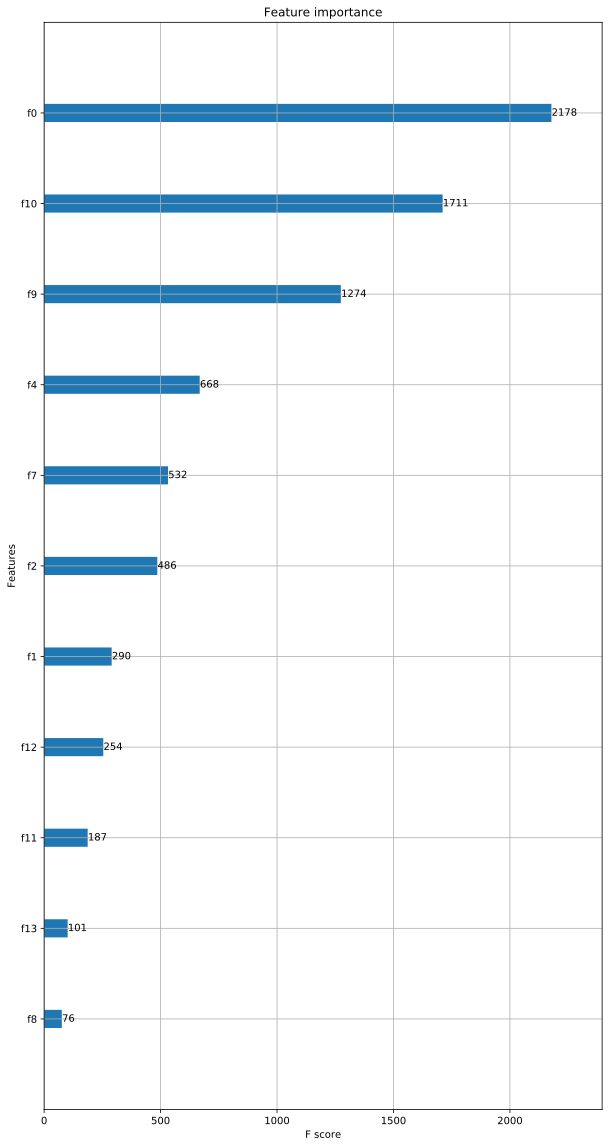

In [29]:
my_plot_importance(model1, (10,20))